# Color clustering with spatial information

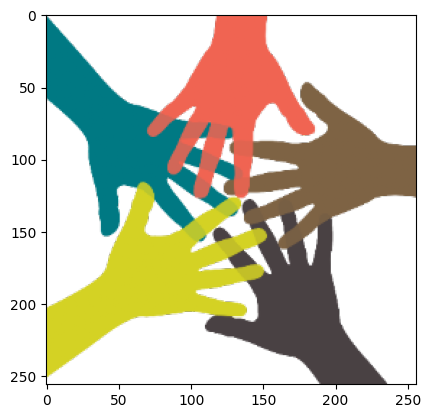

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


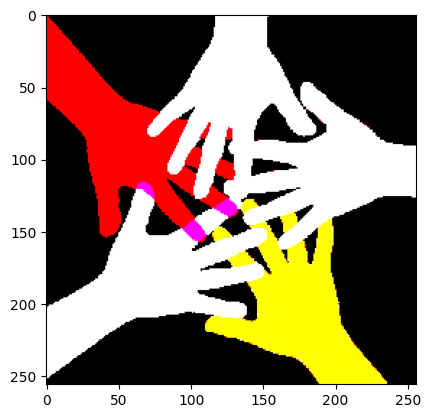

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


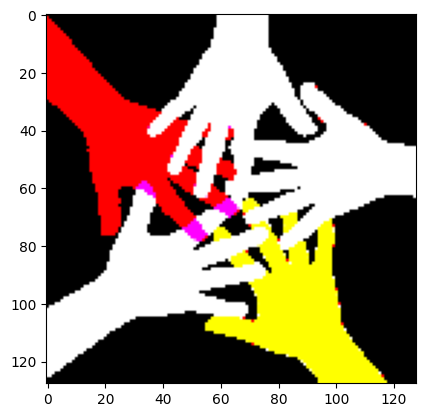

[[ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 ...
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]]


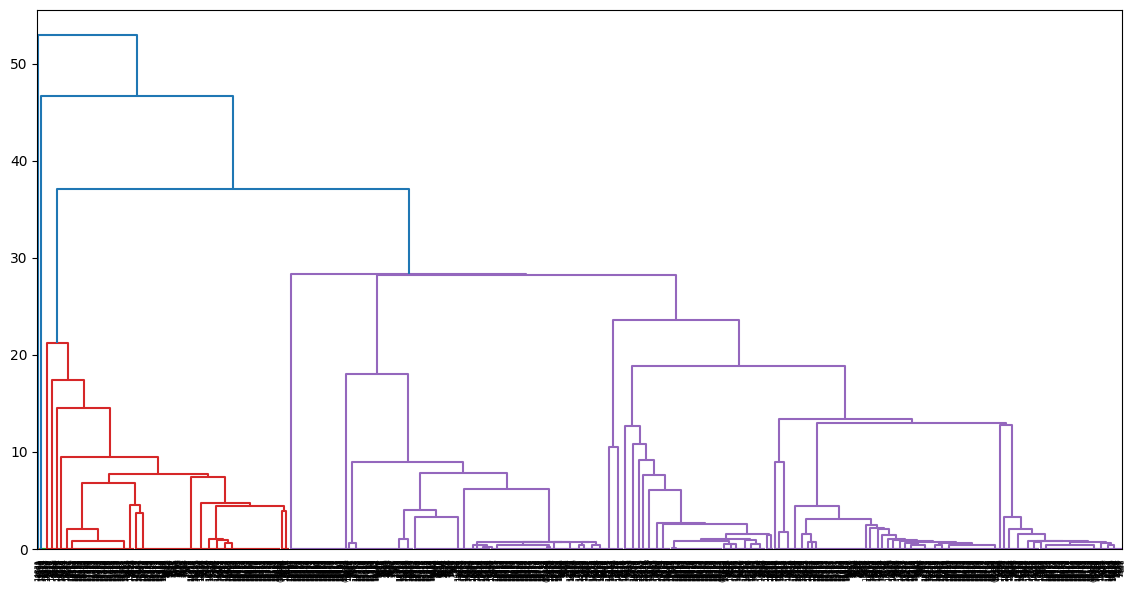

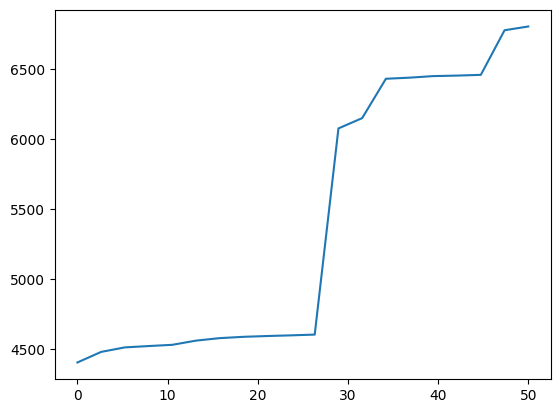

True


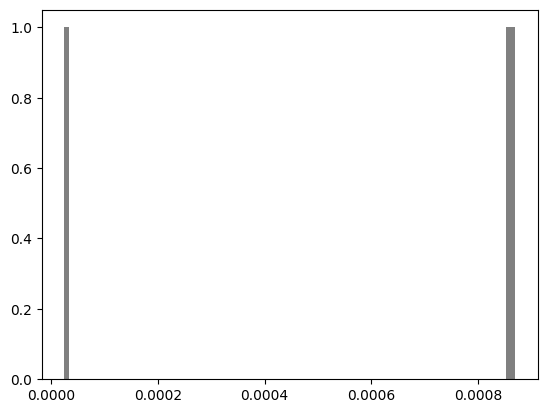

usetex mode requires TeX.


<Figure size 1800x400 with 0 Axes>

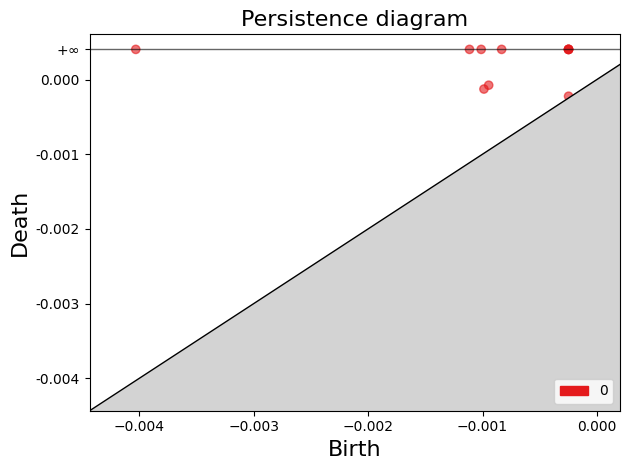

<Figure size 1800x400 with 0 Axes>

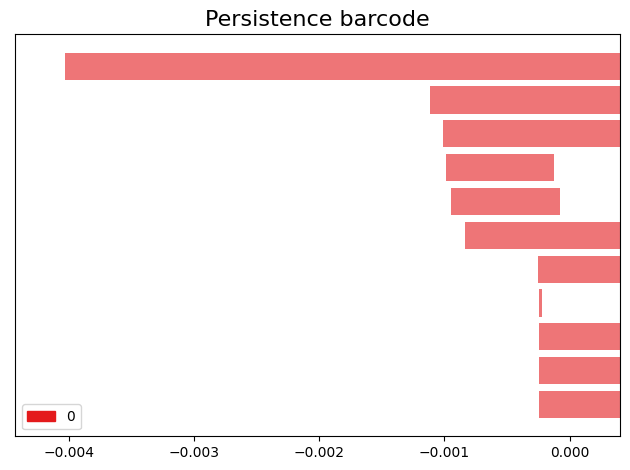

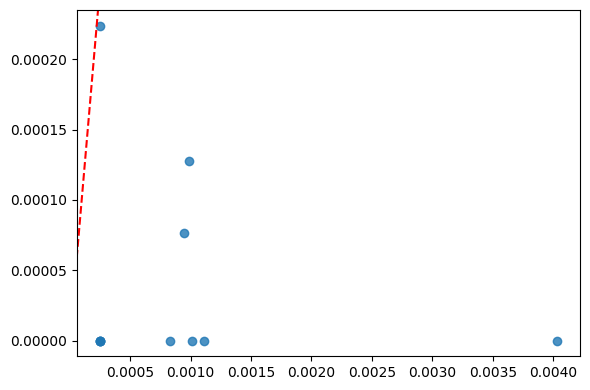

Broj klastera vecih od  20  je  6


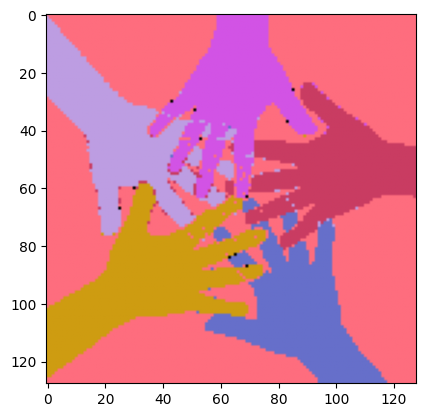

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import gudhi as gd
from sklearn.neighbors import KernelDensity, KDTree
import random
import multiprocessing
from scipy.cluster import hierarchy
import matplotlib.gridspec as gds
import matplotlib
%run ImageSegmentation.ipynb

In [77]:
img_rgb_2 = plt.imread('data/baboon.png', 'PNG')

In [78]:
img_luv_2 = cv2.cvtColor(img_rgb_2, cv2.COLOR_RGB2Luv)

In [79]:
img_luv_2.shape

(512, 512, 3)

# Initializing data

In [80]:
gap = 2
img_luv_2 = np.asarray([[list(img_luv_2[i, j, :]) for j in range(0,img_luv_2.shape[1], gap)]
    for i in np.arange(0,img_luv_2.shape[0], gap)])
img_luv_2.shape

(256, 256, 3)

In [81]:
l, u, v = [], [], []
for i in range(img_luv_2.shape[0]):
    for j in range(img_luv_2.shape[1]):
        l.append(img_luv_2[i, j, 0])
        u.append(img_luv_2[i, j, 1])
        v.append(img_luv_2[i, j, 2])

In [82]:
x = np.vstack((l, u, v)).T
x.shape

(65536, 3)

In [83]:
kde = KernelDensity(bandwidth=2.0, atol=0.0005, rtol=0.01).fit(x) 
log_prob = parallel_score_samples(kde, x)
prob = np.exp(log_prob)

# Calculating Vietoris-Rips complex

In [84]:
matrix = [[i*img_luv_2.shape[0]+j for j in np.arange(img_luv_2.shape[1])] for i in np.arange(img_luv_2.shape[0])]

In [85]:
def matrix_neighbors(a, radius, rowNumber, columnNumber):
     pom = np.array([[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else -1
                for j in range(columnNumber-radius, columnNumber+radius+1)]
                    for i in range(rowNumber-radius, rowNumber+radius+1)]).flatten()
     return [elem for elem in pom if elem!=-1]

In [87]:
nei_pixels_list = [matrix_neighbors(matrix, radius=6, rowNumber=i, columnNumber=j) for i in np.arange(len(matrix[0])) for j in np.arange(len(matrix))]

In [88]:
kdt = KDTree(x, metric='euclidean')

Calculating distances in Luv space for selecting optimal radius

In [89]:
distances = [np.mean(np.linalg.norm(x[ind]-x[elem]))  
              for ind in range(x.shape[0])
              for elem in nei_pixels_list[ind]]

In [90]:
np.mean([elem for elem in distances if elem != 0])

257.5820993275417

In [91]:

np.median([elem for elem in distances])

256.4254277562972

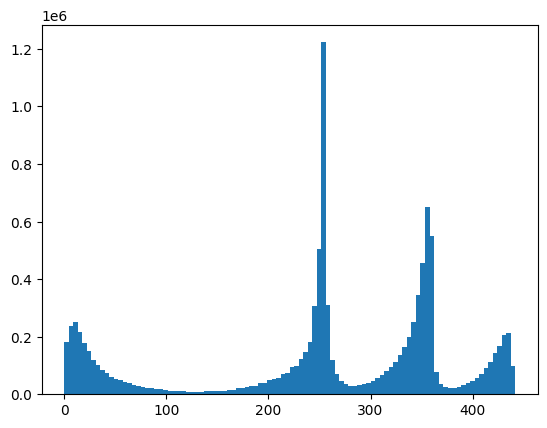

In [93]:
plt.hist(distances, bins=100)
plt.show()

In [94]:
radius = 4

# Main clustering function with spatial information

In [95]:
def define_clusters_spatial(prob, radius, tau, x):
    sorted_indices = np.argsort(prob)
    unf = UnionFind()
    n=len(prob)
    births = {}
    deaths = {}

    for i in reversed(range(n)):
        id = sorted_indices[i]
        nei = kdt.query_radius([x[id]], radius, return_distance=False)[0]
        S = [elem for elem in nei_pixels_list[id] if ((elem in sorted_indices[(i+1):]) & (elem in nei))] 

        if not S:
            unf.insert(id) 
            births[id] = -prob[id]
        else:
            parent = S[np.asarray([prob[j] for j in S]).argmax()]
            unf.union(parent, id)
            ei = unf.find(id)
            roots = [unf.find(ele) for ele in S]
            for ej in roots:                   
                if (ei != ej) & (prob[ej] - prob[id] < tau):
                    unf.union(parent, ej)
                    deaths[ej] = -prob[id]
            e_ = -1
            for ej in roots:
                    if e_ == -1 or prob[unf.find(ej)] > prob[unf.find(e_)]:
                        e_ = ej
            if ei != e_ and prob[unf.find(ei)] - prob[id] < tau:
                    unf.union(e_, ei)
                    deaths[ei] = -prob[id]

    for i in births.keys():
        if i not in deaths.keys():
            deaths[i] = np.inf
    return unf, births, deaths

In [96]:
unf, births, deaths = define_clusters_spatial(prob, radius=radius, tau=np.inf, x=x)

In [97]:
for idx in births.keys():
    if (idx not in deaths.keys()):
        deaths[idx] = np.inf

In [98]:
lifecycle = [(births[idx], deaths[idx]) for idx in births.keys()]

In [99]:
res = [(0, elem) for elem in lifecycle]

In [100]:
persistence = [elem[1]-elem[0] for elem in lifecycle]

<Figure size 1800x400 with 0 Axes>

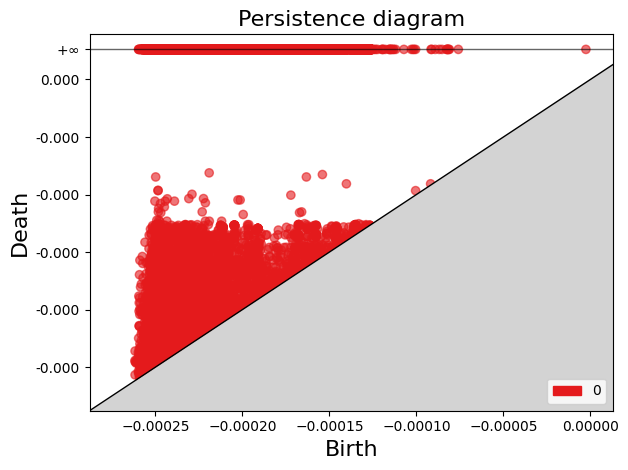

In [101]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_diagram(res)
plt.tight_layout()
plt.show()

c:\Users\necag\AppData\Local\Programs\Python\Python310\lib\site-packages\gudhi\persistence_graphical_tools.py:85: UserWarning: There are 23878 intervals given as input, whereas max_intervals is set to 20000.
  warnings.warn(


<Figure size 1800x400 with 0 Axes>

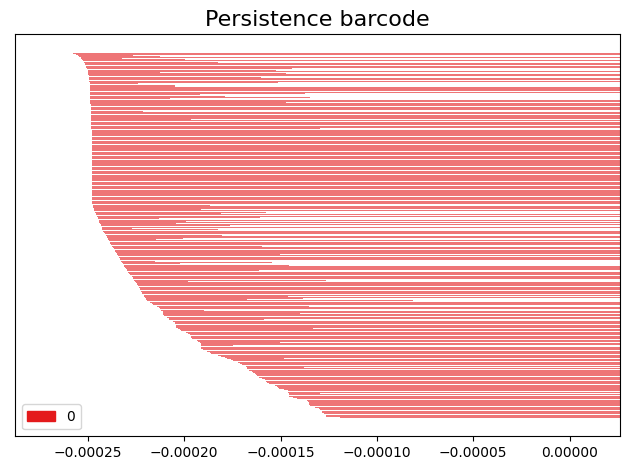

In [102]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gd.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

In [103]:
unf, births, deaths = define_clusters_spatial(prob, radius=radius, tau=1e-5, x=x)

In [104]:
len(np.unique(list(unf.parent.values())))

21220

# Centroid calculation:

In [105]:
cen, sts = [], []
ind = np.asarray(list(unf.num_to_objects.values()))
rts = np.asarray(list(unf.parent.values()))

In [106]:
for ele in np.unique(rts):

    cen.append(unf.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [65]:
cen = np.asarray(cen)

In [126]:
threshold = 20
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

Broj klastera vecih od  20  je  265


# Grouping points belonging to same clusters:

In [127]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+111)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0,0,0])
    return colors
colors = cluster_color(cen)

In [128]:
idxs = []
for idx, grp in enumerate(sts):
    idxs = idxs + list(np.repeat(idx, len(sts[idx])))

In [129]:
grps = []
for idx, grp in enumerate(sts):
    grps = grps + list(grp)

In [130]:
cluster_sort = sorted(zip(grps, idxs))

In [131]:
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]

In [132]:
cluster_sort = sorted(zip(grps, idxs))
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]
len(img_clustered)

65536

In [133]:
img_clustered_all = np.reshape(np.asarray(img_clustered), img_luv_2.shape)
img_clustered_all.shape

(256, 256, 3)

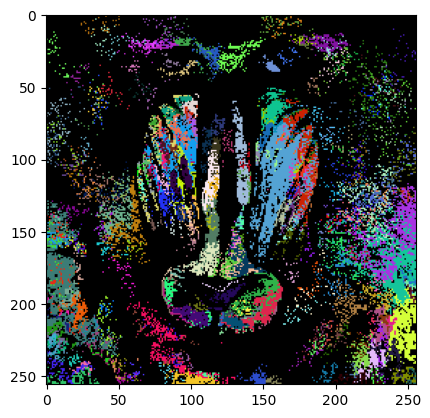

In [134]:
plt.imshow(img_clustered_all)

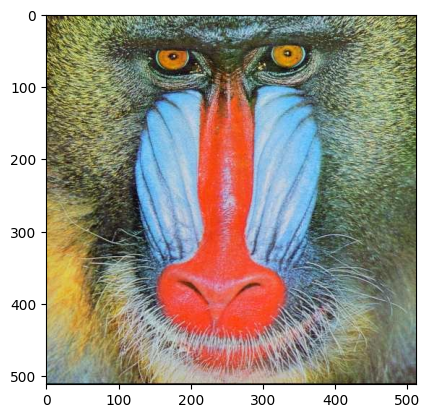

In [116]:
plt.imshow(img_rgb_2)